In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [23]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

import emcee3
from celerite.modeling import Model

In [5]:
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)
    
class RVKernel(Model):
    parameter_names = ("log_vc", "log_vr", "log_lc", "log_bc", "log_br")
    
    def __init__(self, G, *args, **kwargs):
        self.G = G
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
        vc = np.exp(self.log_vc)
        vr = np.exp(self.log_vr)
        lc = np.exp(self.log_lc)
        bc = np.exp(self.log_bc)
        br = np.exp(self.log_br)
        
        # Compute the value of gamma and its derivatives
        g = self.G.get_value(tau)
        gp1 = self.G.get_grad_1_value(tau)
        gp2 = self.G.get_grad_1_value(-tau)
        gpp = self.G.get_grad_2_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g[m] + vr**2*gpp[m] + vr*vc*(gp1 + gp2)[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g[m] + br**2*gpp[m] + bc*br*(gp1 + gp2)[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g[m] + vr*lc*gp2[m]
        m = m12 * m21
        K[m] = vc*lc*g[m] + vr*lc*gp1[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp1[m] + vr*bc*gp2[m]
        m = m13 * m21
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp2[m] + vr*bc*gp1[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g[m] + lc*br*gp1[m]
        m = m13 * m22
        K[m] = lc*bc*g[m] + lc*br*gp2[m]

        return K

In [6]:
func = SimpleKernel(0.1)
kernel = RVKernel(func, 1.0, 1.0, 0.0, 0.0, 0.5)

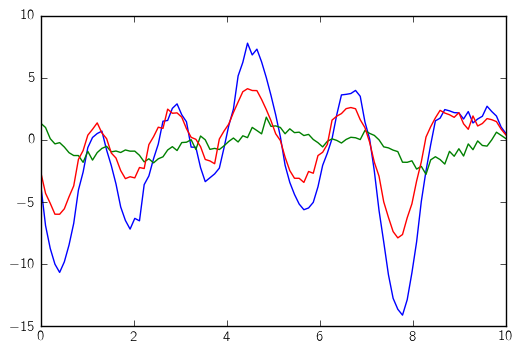

In [7]:
t = np.linspace(0, 10, 100)
l = np.concatenate((1 + np.zeros(len(t)), 2 + np.zeros(len(t)), 3 + np.zeros(len(t)))).astype(int)
t = np.concatenate((t, t, t))
K = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(t))] += 0.1
y = np.random.multivariate_normal(np.zeros_like(t), K)

for i in [1, 2, 3]:
    plt.plot(t[l==i], y[l==i])

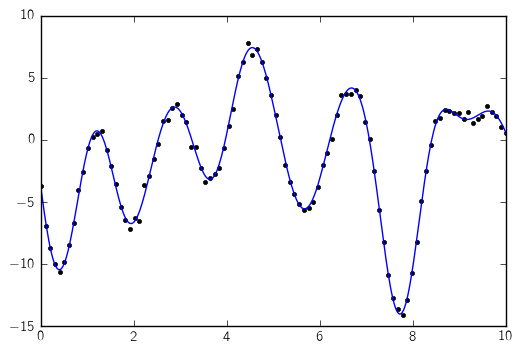

In [11]:
K = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(t))] += 0.1

x = np.linspace(0, 10, 400)
Ks = kernel.get_value(x[:, None] - t[None, :], 1+np.zeros(len(x), dtype=int)[:, None], l[None, :])

mu = np.dot(Ks, np.linalg.solve(K, y))

plt.plot(t[l==1], y[l==1], ".k")
plt.plot(x, mu)

In [12]:
def log_prob(params):
    n = func.vector_size
    func.set_parameter_vector(params[:n])
    kernel.set_parameter_vector(params[n:])
    K = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
    K[np.diag_indices_from(K)] += 0.1
    try:
        L = cho_factor(K, overwrite_a=True)
    except (np.linalg.LinAlgError, ValueError):
        return -np.inf
    logdet = 2.0 * np.sum(np.log(np.diag(L[0])))
    ll = -0.5 * (np.dot(y, cho_solve(L, y)) + logdet)
    if not np.isfinite(ll):
        return -np.inf
    return ll

p0 = np.append(func.get_parameter_vector(), kernel.get_parameter_vector())
print(log_prob(p0))
p0 = p0 + 1e-5*np.random.randn(32, len(p0))
sampler = emcee3.Sampler()

pool = emcee3.pools.InterruptiblePool()
ensemble = emcee3.Ensemble(emcee3.SimpleModel(log_prob), p0, pool=pool)

118.56898395


In [20]:
ensemble = sampler.run(ensemble, 2000, progress=True)

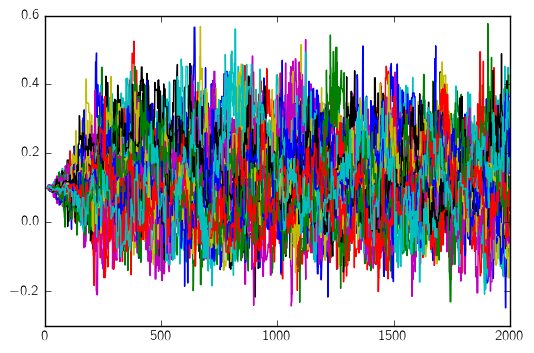

In [22]:
chain = sampler.get_coords()
lp = sampler.get_log_probability()
plt.plot(chain[:, :, 0]);

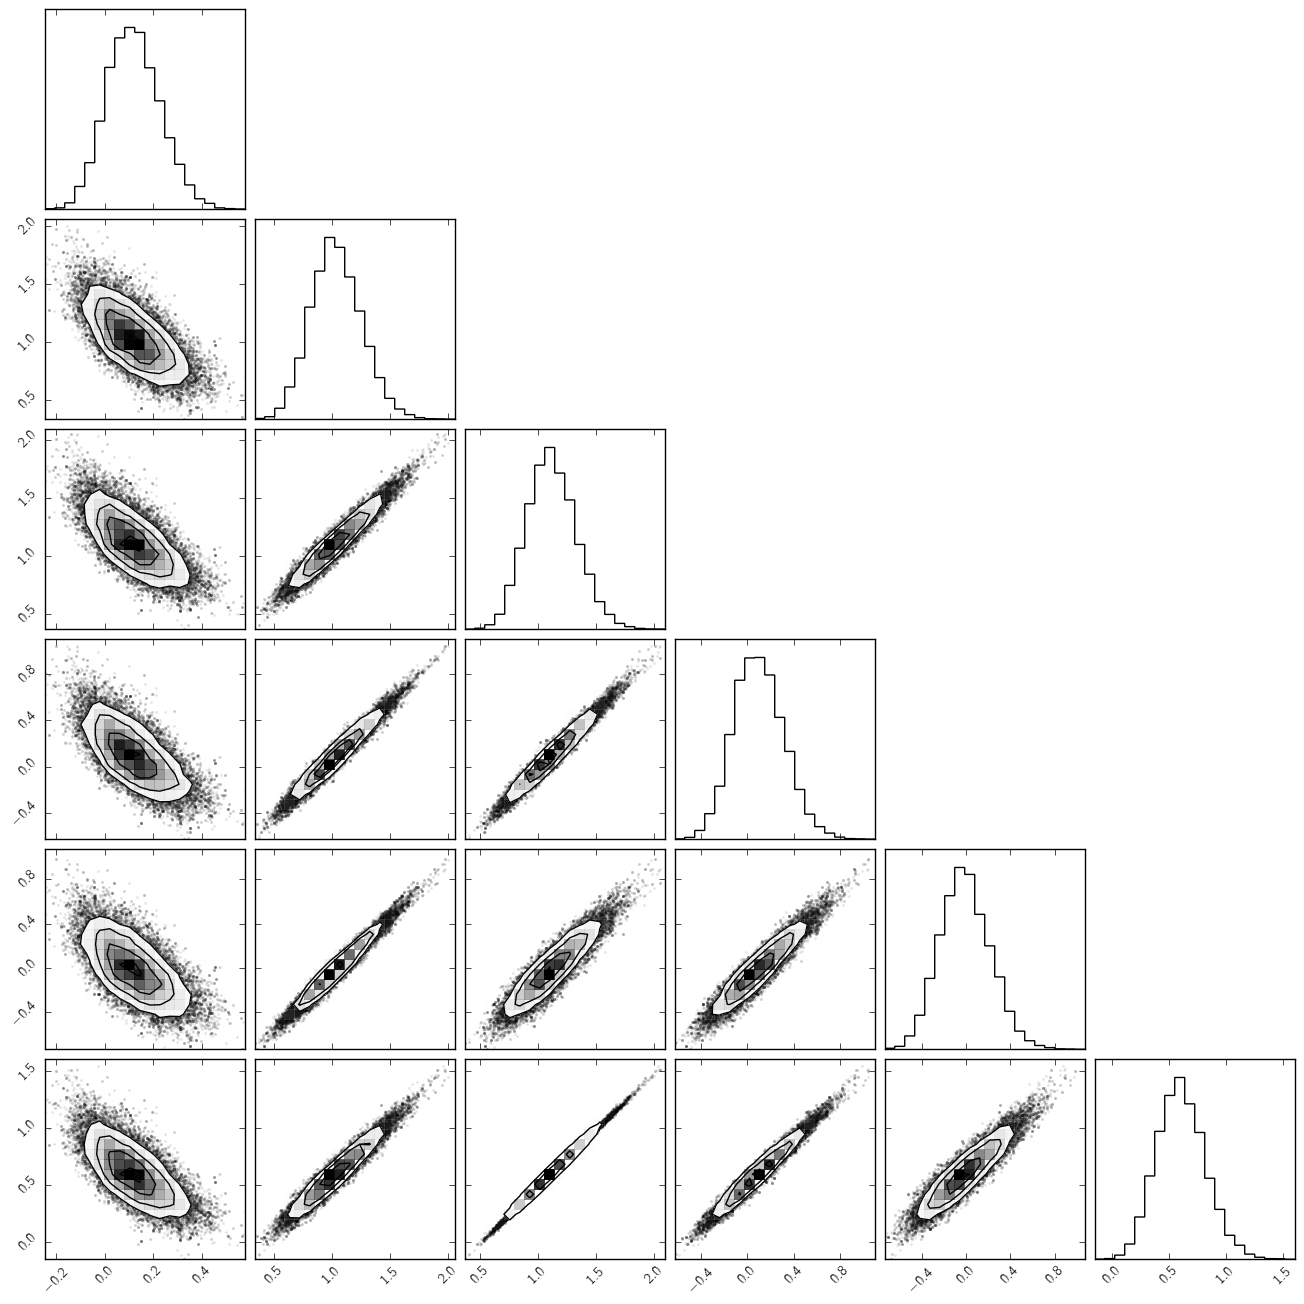

In [24]:
samples = sampler.get_coords(discard=500, flat=True)
corner.corner(samples);

[ 0.27537163  0.79643278  0.89598266 -0.12854974 -0.25947569  0.39059936]


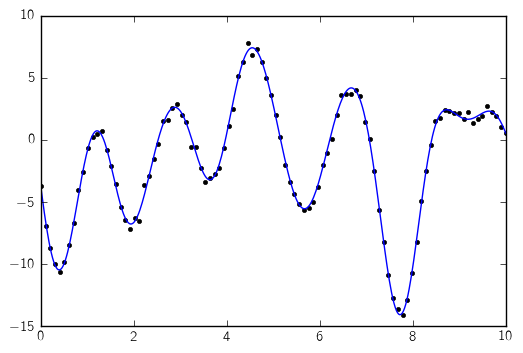

In [25]:
params = samples[-1]
print(params)
n = func.vector_size
func.set_parameter_vector(params[:n])
kernel.set_parameter_vector(params[n:])

K = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(t))] += 0.1

x = np.linspace(0, 10, 400)
Ks = kernel.get_value(x[:, None] - t[None, :], 1+np.zeros(len(x), dtype=int)[:, None], l[None, :])

mu = np.dot(Ks, np.linalg.solve(K, y))

plt.plot(t[l==1], y[l==1], ".k")
plt.plot(x, mu)